<a href="https://colab.research.google.com/github/AndrewRomitti/DeiT_Dementia/blob/main/4Class_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HuggingFace Data Efficient Image Transformer for Dementia Diagnosis

In [ ]:
print("Starting Notebook")

Starting Notebook


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
  import datasets, evaluate, transformers
except:
  !pip install transformers datasets evaluate transformers[torch] > /dev/null 2>$1
  import datasets, evaluate, transformers
  print("Successfully installed libraries")

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (8).json to kaggle (8).json


{'kaggle (8).json': b'{"username":"andrewromitti1","key":"124255a4fc9835b858bfb26fef614595"}'}

In [ ]:
!pip install -q kaggle > /dev/null 2>&1

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ninadaithal/imagesoasis

100% 1.23G/1.23G [00:09<00:00, 148MB/s]
100% 1.23G/1.23G [00:09<00:00, 144MB/s]


In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images > /dev/null 2>&1

In [ ]:
!unzip /content/imagesoasis.zip > /dev/null 2>&1
print("Unzipped")

Unzipped


In [ ]:
import os

PATH = r"/content/Data/"

for dir in os.listdir(PATH):
  print(dir)

Moderate Dementia
Non Demented
Mild Dementia
Very mild Dementia


Text(0.5, 0, 'Number of Images')

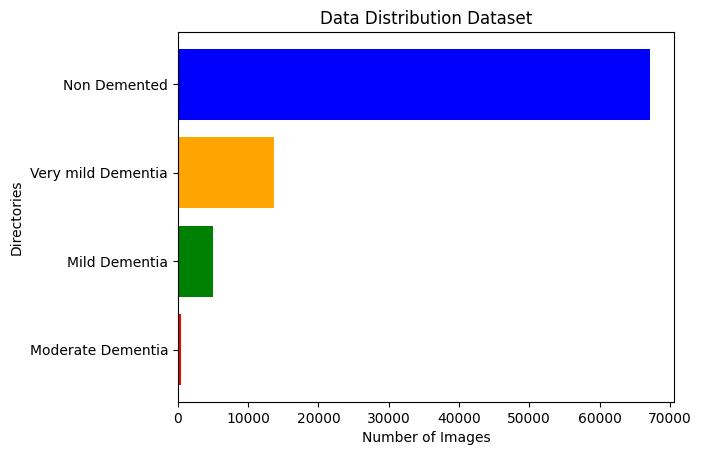

In [ ]:
import os
import matplotlib.pyplot as plt


#Data Distribution for Training
PATH = r"/content/Data"

x_axis = ["Non Demented", "Very mild Dementia", "Mild Dementia", "Moderate Dementia"]
x_axis = x_axis[::-1]
colors = ["red", "green","orange","blue"]
y_axis = []

for dir in x_axis:
  target_dir = PATH + "/" + dir
  files = os.listdir(target_dir)
  count = len(files)
  y_axis.append(count)

plt.barh(x_axis, y_axis,color=colors)
plt.title("Data Distribution Dataset")
plt.ylabel("Directories")
plt.xlabel("Number of Images")

In [ ]:
os.listdir(PATH)

['Moderate Dementia', 'Non Demented', 'Very mild Dementia', 'Mild Dementia']

In [ ]:
import shutil

PATH = PATH

for dir in os.listdir(PATH):
  for fiel in os.listdir(PATH+"/"+dir+"/"):
    print(fiel)
    shutil.move(PATH+"/"+dir+"/"+fiel, r"/content/drive/MyDrive/MRI_Project/SyntheticDs2/train"+"/"+dir+"/")

Streaming output truncated to the last 5000 lines.
mildDem708.jpg
mildDem524.jpg
mildDem391.jpg
mildDem352.jpg
mildDem530.jpg
mildDem655.jpg
mildDem279.jpg
mildDem240.jpg
mildDem539.jpg
mildDem347.jpg
mildDem516.jpg
mildDem214.jpg
mildDem671.jpg
mildDem243.jpg
mildDem358.jpg
mildDem416.jpg
mildDem300.jpg
mildDem625.jpg
mildDem519.jpg
mildDem127.jpg
mildDem146.jpg
mildDem19.jpg
mildDem436.jpg
mildDem426.jpg
mildDem702.jpg
mildDem454.jpg
mildDem648.jpg
mildDem270.jpg
mildDem107.jpg
mildDem684.jpg
mildDem234.jpg
mildDem218.jpg
mildDem341.jpg
mildDem97.jpg
mildDem485.jpg
mildDem208.jpg
mildDem598.jpg
mildDem591.jpg
mildDem511.jpg
mildDem502.jpg
mildDem418.jpg
mildDem462.jpg
mildDem139.jpg
mildDem415.jpg
mildDem588.jpg
mildDem538.jpg
mildDem121.jpg
mildDem556.jpg
mildDem470.jpg
mildDem607.jpg
mildDem159.jpg
mildDem356.jpg
mildDem482.jpg
mildDem21.jpg
mildDem209.jpg
mildDem388.jpg
mildDem576.jpg
mildDem3.jpg
mildDem150.jpg
mildDem484.jpg
mildDem257.jpg
mildDem360.jpg
mildDem109.jpg
mildDem66

In [ ]:
import numpy as np

y_axis = np.array(y_axis)
weights = 1./y_axis

In [ ]:
import datasets

#If training GAN
ds = datasets.load_dataset("imagefolder", data_dir=r"/content/Alzheimer_s Dataset")

#If training Real Data
#ds = datasets.load_dataset("imagefolder", data_dir=r'/content/Alzheimer_s Dataset')
ds_train = ds["train"].shuffle(seed=1)
ds_test = ds["test"]

Resolving data files:   0%|          | 0/5121 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1279 [00:00<?, ?it/s]

In [ ]:
checkpoint = "facebook/deit-base-distilled-patch16-224"

image_processor = transformers.AutoImageProcessor.from_pretrained(checkpoint, return_tensors="pt")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
len(ds_train)

5121

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.autoaugment import AutoAugmentPolicy

train_tfs = Compose([
      T.AutoAugment(AutoAugmentPolicy.IMAGENET),
      T.ElasticTransform(),
      Resize(size=(224,224)),
      ToTensor(),
      Normalize(mean=[0.5],
                std=[0.5])
    ]
    )

test_tfs = Compose(
    [
      Resize(size=(224,224)),
      ToTensor(),
      Normalize(mean=[0.5],
                std=[0.5])
    ]
)

def train_transforms(example):
  example["pixel_values"] = [train_tfs(image.convert("RGB")) for image in example["image"]]
  del example["image"]
  return example

def test_transforms(example):
  example["pixel_values"] = [test_tfs(image.convert("RGB")) for image in example["image"]]
  del example["image"]
  return example

ds["train"] = ds["train"].with_transform(train_transforms)
ds["test"] = ds["test"].with_transform(test_transforms)

In [ ]:
ds["train"]

In [ ]:
import evaluate
import numpy as np

f1 = evaluate.load("f1")
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": np.mean(predictions == labels)}

In [ ]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
data_collator = transformers.DefaultDataCollator(return_tensors="pt")

In [ ]:
model = transformers.DeiTForImageClassification.from_pretrained(checkpoint,
                               num_labels=len(labels),
                               id2label=id2label,
                               label2id=label2id,
                               ignore_mismatched_sizes=True,
                               )

model.config = transformers.DeiTConfig(hidden_dropout_prob=0.1, attention_probs_dropout_prob = 0.1)

model = model.to("cuda")

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
temp = y_axis[2]
temp_2 = y_axis[3]

y_axis[3] = y_axis[0]
y_axis[2] = temp_2
y_axis[0] = y_axis[1]
y_axis[1] = temp

y_axis

array([ 221, 2710, 1876,  967])

In [ ]:
def compute_class_weights(class_counts):
  updated_counts = []
  total = sum(y_axis)
  for count in class_counts:
    updated_counts.append(1-(count/total))

  return np.array(updated_counts)

class_weights = torch.tensor(compute_class_weights(y_axis),dtype=torch.float)

In [ ]:
import torch.nn as nn

class WeightedTransformer(transformers.Trainer):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to("cuda" if torch.cuda.is_available() else "cpu"))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
args = transformers.TrainingArguments(
    output_dir="alzheimer_model_aug_deit60",
    overwrite_output_dir=True,
    remove_unused_columns=False,


    weight_decay=0.01,
    warmup_steps=6,

    logging_steps=1800//20,
    num_train_epochs=100,
    evaluation_strategy="epoch",
    per_device_eval_batch_size=32,
    per_device_train_batch_size=32,
    metric_for_best_model="accuracy",
    gradient_accumulation_steps=4,
    eval_accumulation_steps=3,


    load_best_model_at_end=True,
    greater_is_better=True,
    save_strategy="epoch",
    seed=1234,


)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers.optimization import Adafactor, AdafactorSchedule

optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)
lr_scheduler = AdafactorSchedule(optimizer)

KeyError: ignored

In [ ]:
trainer = WeightedTransformer(
    model=model,
    args=args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics, #If numbers are dissapointing delete this line of code
)

In [ ]:
trainer = transformers.Trainer(
    model=model,
    args=args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset = ds["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

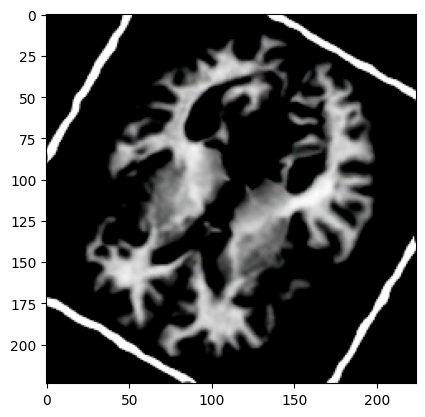

In [ ]:
plt.imshow(ds["train"][100]["pixel_values"].permute(1,2,0))

In [ ]:
#!pip install git+https://github.com/huggingface/accelerate
#!pip install --upgrade transformers

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.841946,0.730258
1,No log,0.802651,0.738858
2,0.146000,0.822629,0.748241
4,0.146000,0.811353,0.762314
4,0.101500,0.760511,0.750586
5,0.101500,0.820558,0.760751
6,0.095400,1.726696,0.667709
8,0.095400,1.187780,0.713839
8,0.087900,0.956595,0.744332
9,0.087900,0.933558,0.743550


TrainOutput(global_step=4000, training_loss=0.03684484742209315, metrics={'train_runtime': 14950.0967, 'train_samples_per_second': 34.254, 'train_steps_per_second': 0.268, 'total_flos': 3.943948873123846e+19, 'train_loss': 0.03684484742209315, 'epoch': 99.38})